In [1]:
import pickle
import pandas as pd
import urllib.request
import matplotlib.pyplot as plt
import os
import numpy as np

data_url = "https://data.lacity.org/api/views/2nrs-mtv8/rows.csv?accessType=DOWNLOAD"

# download data
if not os.path.isfile("data.csv"):
    urllib.request.urlretrieve(data_url, "data.csv")

"""
Use the store_object function to make local caching of the data.
"""
def store_object(filename, instruction):
    # check if file was cached before and read it
    if os.path.isfile(filename):
        return pickle.load(open(filename, 'rb'))
    # run instruction and save it as pickle then return object
    else:
        obj = instruction()
        pickle.dump(obj, open(filename, 'wb'))
        return obj
    
data = store_object("data.pkl", lambda: pd.read_csv("data.csv"))

# clean data

data = data[data["Vict Age"] >= 0]

# create 'DATE OCC' column to be merged DATE and TIME OCC - DATE represents the date of the incident and TIME OCC represents the time of the incident
data["DATE OCC"] = pd.to_datetime(data["DATE OCC"], format="%m/%d/%Y %I:%M:%S %p")
data["TIME OCC"] = pd.to_datetime(data["TIME OCC"].astype(str).str.zfill(4), format='%H%M')
data["DATE OCC"] = data["DATE OCC"].dt.date.astype(str) + " " + data["TIME OCC"].dt.time.astype(str)
data["DATE OCC"] = pd.to_datetime(data["DATE OCC"])

# drop 'TIME OCC' column
data = data.drop(columns=["TIME OCC"])

# drop everything after 2024/01/01 as data is incomplete
data = data[data["DATE OCC"] < "2024-01-01"]

data.head()

,DR_NO,Date Rptd,DATE OCC,AREA,AREA NAME,Rpt Dist No,Part 1-2,Crm Cd,Crm Cd Desc,Mocodes,...,Status,Status Desc,Crm Cd 1,Crm Cd 2,Crm Cd 3,Crm Cd 4,LOCATION,Cross Street,LAT,LON
0,190326475,03/01/2020 12:00:00 AM,2020-03-01 21:30:00,7,Wilshire,784,1,510,VEHICLE - STOLEN,NaN,...,AA,Adult Arrest,510.0,998.0,NaN,NaN,1900 S LONGWOOD AV,NaN,34.0375,-118.3506
1,200106753,02/09/2020 12:00:00 AM,2020-02-08 18:00:00,1,Central,182,1,330,BURGLARY FROM VEHICLE,1822 1402 0344,...,IC,Invest Cont,330.0,998.0,NaN,NaN,1000 S FLOWER ST,NaN,34.0444,-118.2628
2,200320258,11/11/2020 12:00:00 AM,2020-11-04 17:00:00,3,Southwest,356,1,480,BIKE - STOLEN,0344 1251,...,IC,Invest Cont,480.0,NaN,NaN,NaN,1400 W 37TH ST,NaN,34.0210,-118.3002
3,200907217,05/10/2023 12:00:00 AM,2020-03-10 20:37:00,9,Van Nuys,964,1,343,SHOPLIFTING-GRAND THEFT ($950.01 & OVER),0325 1501,...,IC,Invest Cont,343.0,NaN,NaN,NaN,14000 RIVERSIDE DR,NaN,34.1576,-118.4387
4,220614831,08/18/2022 12:00:00 AM,2020-08-17 12:00:00,6,Hollywood,666,2,354,THEFT OF IDENTITY,1822 1501 0930 2004,...,IC,Invest Cont,354.0,NaN,NaN,NaN,1900 TRANSIENT,NaN,34.0944,-118.3277


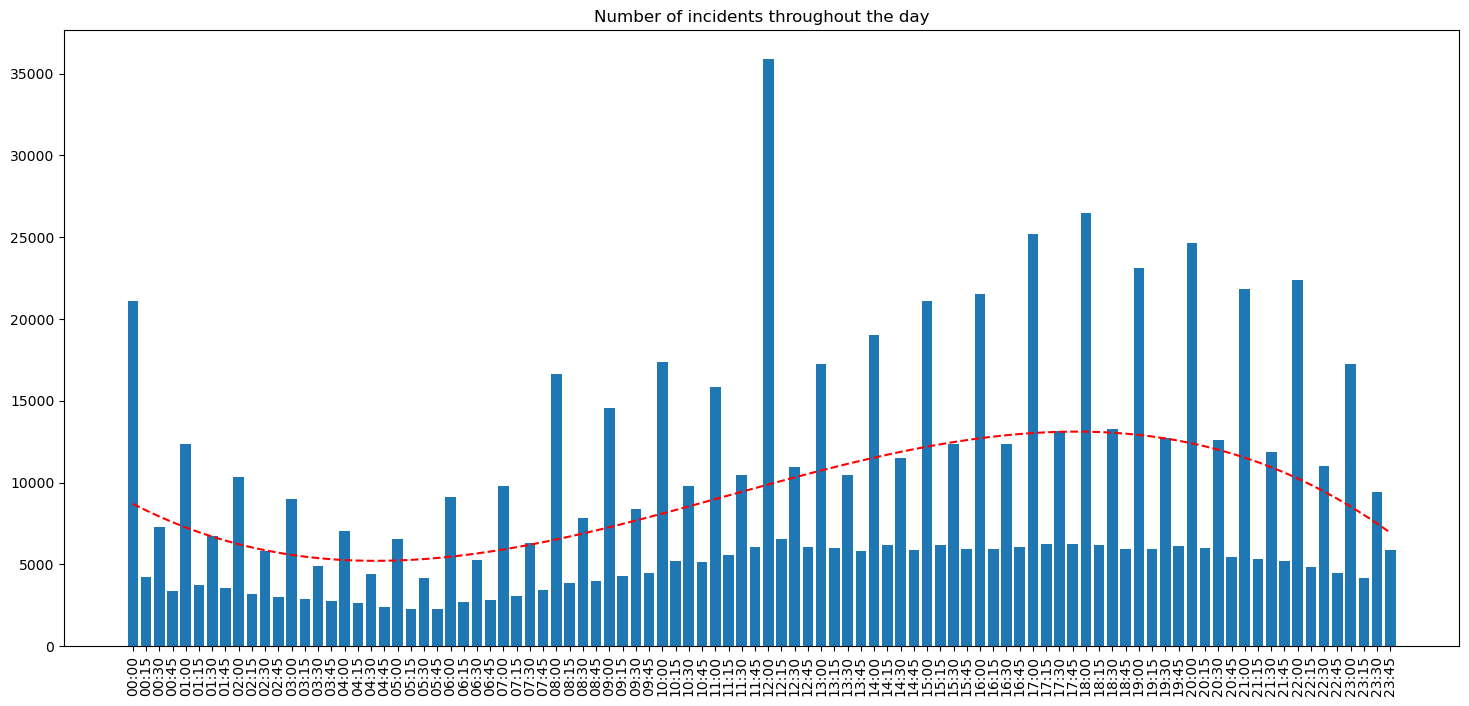

In [2]:
timeframe = "15min"
intervals = pd.date_range(start='00:00:00', freq=timeframe, periods=96).time

# group by interval of timeframes
resampled_data = data
resampled_data = resampled_data.groupby([resampled_data["DATE OCC"].dt.floor(timeframe).dt.time])

resampled_data = [g for _, g in resampled_data]

def repr_interval(interval):
    return interval.strftime("%H:%M")

# plot bar
fig, ax = plt.subplots(figsize=(18, 8))
ax.bar([repr_interval(interval) for interval in intervals], [len(g) for g in resampled_data])
plt.xticks(rotation=90)
plt.title("Number of incidents throughout the day")

# draw aproximate function of the data
x = [i for i in range(len(intervals))]
y = [len(g) for g in resampled_data]
z = np.polyfit(x, y, 3)
p = np.poly1d(z)

plt.plot([repr_interval(interval) for interval in intervals], p(x), "r--")

plt.show()


In [3]:
# print the most popular incidents types for each time interval in format (HH:MM, incident types [seperateed by comma and space; maximum 5 types per interval])
def get_most_popular_incidents_types(interval):
    return interval["Crm Cd Desc"].value_counts()

most_popular_incident_types = [get_most_popular_incidents_types(interval) for interval in resampled_data]

for i in range(len(intervals)):
    print(f"{repr_interval(intervals[i])}, {most_popular_incident_types[i].index[:5].values}")


00:00, ['THEFT OF IDENTITY' 'VEHICLE - STOLEN' 'BURGLARY' 'BURGLARY FROM VEHICLE'
 'VANDALISM - FELONY ($400 & OVER, ALL CHURCH VANDALISMS)']
00:15, ['THEFT OF IDENTITY' 'BATTERY - SIMPLE ASSAULT'
 'ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT'
 'INTIMATE PARTNER - SIMPLE ASSAULT'
 'VANDALISM - FELONY ($400 & OVER, ALL CHURCH VANDALISMS)']
00:30, ['VEHICLE - STOLEN' 'INTIMATE PARTNER - SIMPLE ASSAULT'
 'ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT'
 'BATTERY - SIMPLE ASSAULT'
 'VANDALISM - FELONY ($400 & OVER, ALL CHURCH VANDALISMS)']
00:45, ['ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT'
 'BATTERY - SIMPLE ASSAULT' 'INTIMATE PARTNER - SIMPLE ASSAULT'
 'THEFT OF IDENTITY'
 'VANDALISM - FELONY ($400 & OVER, ALL CHURCH VANDALISMS)']
01:00, ['VEHICLE - STOLEN' 'BURGLARY FROM VEHICLE'
 'INTIMATE PARTNER - SIMPLE ASSAULT' 'THEFT OF IDENTITY'
 'BATTERY - SIMPLE ASSAULT']
01:15, ['ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT'
 'BATTERY - SIMPLE ASSAULT' 'BURGLARY' 'INTIMATE PARTNER - 

In [4]:
unique_incidents = pd.concat(most_popular_incident_types)
unique_incidents = unique_incidents.groupby(unique_incidents.index).sum().sort_values(ascending=False)

unique_incidents = unique_incidents.index.unique()

# print pandas without dots
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)
print(unique_incidents)

Index(['VEHICLE - STOLEN', 'BATTERY - SIMPLE ASSAULT', 'THEFT OF IDENTITY',
       'BURGLARY FROM VEHICLE', 'BURGLARY',
       'VANDALISM - FELONY ($400 & OVER, ALL CHURCH VANDALISMS)',
       'ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT',
       'THEFT PLAIN - PETTY ($950 & UNDER)',
       'INTIMATE PARTNER - SIMPLE ASSAULT',
       'THEFT FROM MOTOR VEHICLE - PETTY ($950 & UNDER)',
       ...
       'GRAND THEFT / AUTO REPAIR', 'PICKPOCKET, ATTEMPT',
       'BLOCKING DOOR INDUCTION CENTER', 'BIKE - ATTEMPTED STOLEN',
       'THEFT, COIN MACHINE - ATTEMPT',
       'FIREARMS EMERGENCY PROTECTIVE ORDER (FIREARMS EPO)',
       'INCEST (SEXUAL ACTS BETWEEN BLOOD RELATIVES)',
       'FIREARMS RESTRAINING ORDER (FIREARMS RO)', 'FAILURE TO DISPERSE',
       'DISHONEST EMPLOYEE ATTEMPTED THEFT'],
      dtype='object', name='Crm Cd Desc', length=138)
